[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Albly/Sparce_image_reconstruction/blob/master/notebooks/tests.ipynb)

In [3]:
from IPython import get_ipython
import os 
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 2

# check if we use colab or local machine
if 'google.colab' in str(get_ipython()):
    IS_COLAB = True
    print('Running on colab')
else:
    IS_COLAB = False
    print('Running on local machine')

if IS_COLAB:
    git_root = !git rev-parse --show-toplevel
    already_in_repo = os.path.exists(git_root[0])

    if not already_in_repo:
        !git clone https://github.com/Albly/Sparce_image_reconstruction $repo_dir

    sys.path.append('Sparce_image_reconstruction')

else:
    os.chdir(Path().absolute().parent)

Running on local machine


In [5]:
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm, trange
from scipy import sparse
import numpy as np

from metrics import *
from utils import *
from recoverers import activations as act
from recoverers.classical import *

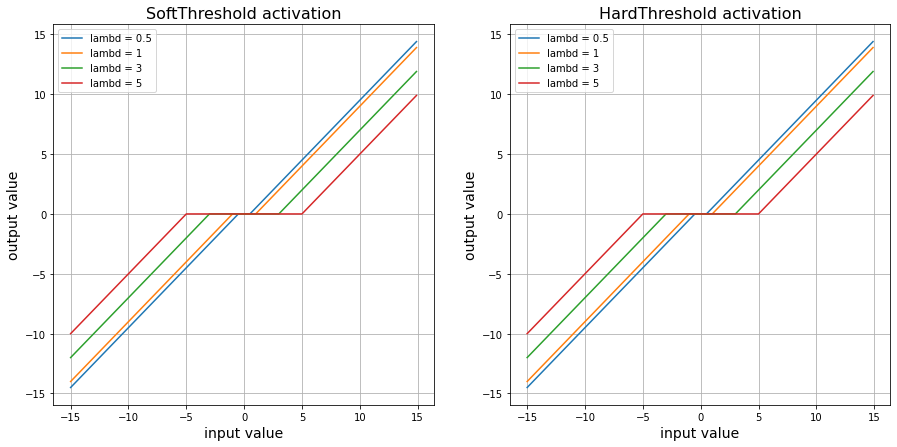

In [3]:
### Test of SoftThresholding and HardThresholding activation
x = torch.arange(-15,15, 0.1)
lambdas = [0.5, 1, 3, 5]

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)

# SoftThresholding
for lambd in lambdas:
    out = act.threshold(x,lambd,'soft')
    plt.plot(x,out, label = 'lambd = '+ str(lambd))

plt.grid()
plt.xlabel('input value', fontsize = 14)
plt.ylabel('output value', fontsize = 14)
plt.title('SoftThreshold activation', fontsize = 16)
plt.legend()

plt.subplot(1,2,2)
for lambd in lambdas:
    out = act.threshold(x,lambd,'soft')
    plt.plot(x,out, label = 'lambd = '+ str(lambd))

plt.grid()
plt.legend()
plt.xlabel('input value', fontsize = 14)
plt.ylabel('output value', fontsize = 14)
plt.title('HardThreshold activation', fontsize = 16)

plt.show()



Iterative methods: for random signal

In [4]:
M = 250 # output vector size
N = 500 # input vector size

x = sparse.rand(m = N, n = 1, density = 0.1) # generate random sparce vector
A = get_Gaussian_matrix(M,N)

x = torch.tensor(x.A, dtype = torch.float32)
A = torch.tensor(A, dtype = torch.float32)

n = get_noise(A@x , 10)

y = A@x + n


In [5]:
x_hat, nmses = ista_denoise(y,A,x, 0.02, 2000)
x_hat2, nmses2 = fista_denoise(y,A,x, 0.02,2000)
x_hat3, nmses3 = amp_denoise(y,A,x, 0.45,500)

Text(0, 0.5, 'SNR [dB]')

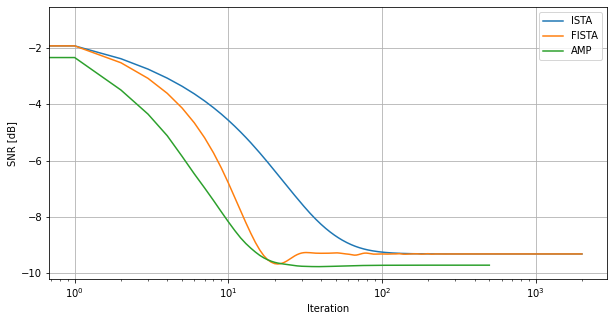

In [6]:
plt.figure(figsize = (10,5))
plt.plot(toDb(nmses), label ='ISTA')
plt.plot(toDb(nmses2), label ='FISTA')
plt.plot(toDb(nmses3), label ='AMP')
#plt.plot(toDb(torch.tensor(metrics)), label ='LISTA')

plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR [dB]')

In [41]:
# lernable algorithm 

from recoverers.lernable import Lista

lista = Lista(A = A, layers = 16)
optimizer = torch.optim.Adam(lista.parameters(), lr = 1.0e-4)
loss_f = torch.nn.MSELoss()

losses = []
metrics = []
for i in range(1000):
    optimizer.zero_grad()

    x_hat = lista.forward(y)
    
    
    loss_value = loss_f(x_hat, x)
    metric = NMSE(x_hat, x)

    losses.append(loss_value)
    metrics.append(metric)

    loss_value.backward()
    optimizer.step()

RuntimeError: "mse_cpu" not implemented for 'ComplexDouble'

Text(0, 0.5, 'SNR [dB]')

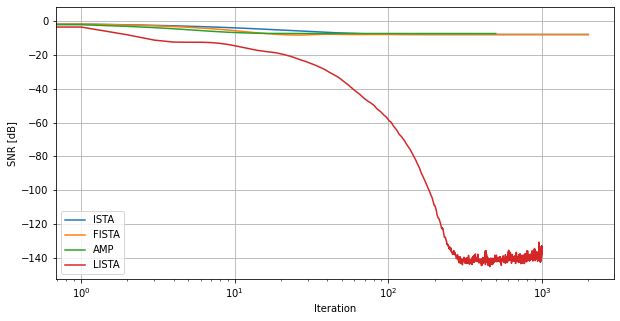

In [8]:
plt.figure(figsize = (10,5))
plt.plot(toDb(nmses), label ='ISTA')
plt.plot(toDb(nmses2), label ='FISTA')
plt.plot(toDb(nmses3), label ='AMP')
plt.plot(toDb(torch.tensor(metrics)), label ='LISTA')

plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR [dB]')

Images


In [7]:
from sklearn.datasets import fetch_openml
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

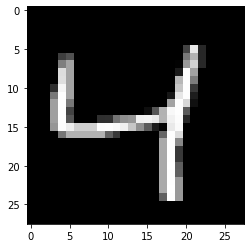

In [8]:
x = np.copy(X[2,:].reshape(28,28))
plt.imshow(x, cmap = 'gray')

0.15306122448979592


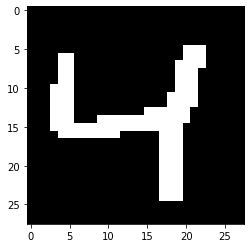

In [9]:
g = np.reshape(np.copy(x), (-1,1))
g[g!=0] = 10**6

print(len(g[g!=0]) /len(g)) 

plt.imshow(np.reshape(g,(28,28)), cmap = 'gray')

In [10]:
x = x.reshape(-1,1)

# measurement matrix
A = np.random.normal(size = (500 , 784), scale = 1.0/np.sqrt(500)).astype(np.float32) # random matrix 
A = A/np.linalg.norm(A,2)


A = torch.tensor(A,dtype = torch.float32)
x = torch.tensor(x,dtype = torch.float32)
n = get_noise(A@x, 40)

y = A@x+n


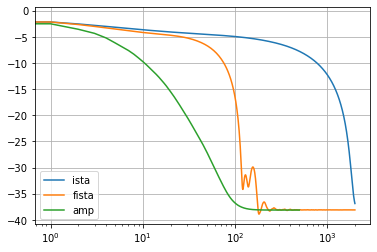

In [11]:
x_hat, nmses = ista_denoise(y,A,x, 0.1, 2000)
x_hat2, nmses2 = fista_denoise(y,A,x, 0.1,2000)
x_hat3, nmses3 = amp_denoise(y,A,x, 0.4, 500)
plt.plot(10*np.log10(nmses), label ='ista')
plt.plot(10*np.log10(nmses2), label ='fista')
plt.plot(10*np.log10(nmses3), label ='amp')
plt.xscale('log')
plt.legend()
plt.grid()

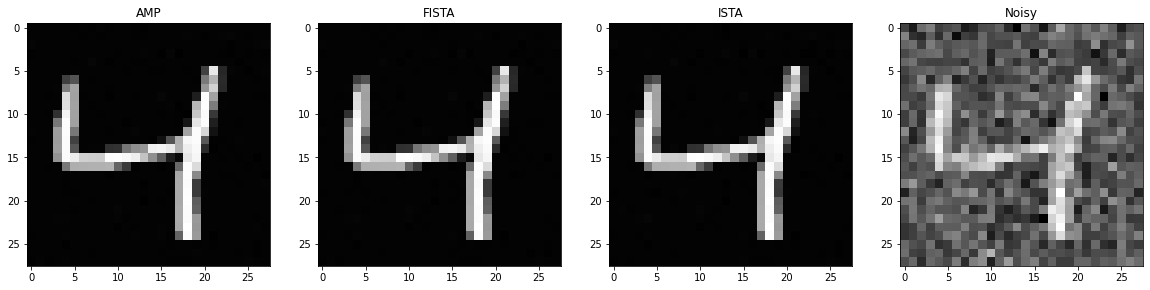

In [12]:
plt.figure(figsize =(20,5))

plt.subplot(1,4,1)
plt.imshow(x_hat3.reshape(28,28), cmap = 'gray')
plt.title('AMP')

plt.subplot(1,4,2)
plt.imshow(x_hat2.reshape(28,28), cmap = 'gray')
plt.title('FISTA')

plt.subplot(1,4,3)
plt.imshow(x_hat.reshape(28,28), cmap = 'gray')
plt.title('ISTA')

plt.subplot(1,4,4)
plt.title('Noisy')
plt.imshow((torch.linalg.pinv(A)@y) .reshape(28,28), cmap = 'gray')

Complex ???


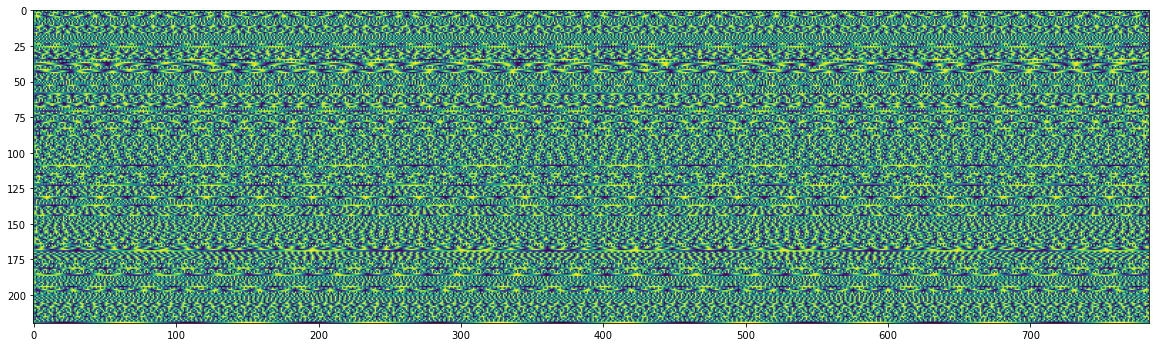

In [13]:

def get_sparcity(x):
    zeros = len(x[x < 0.01])
    return zeros/len(x)

M = 220
N = 784

A = get_partial_FFT(M,N)
x = x.type(torch.complex128)
y = A@x

plt.figure(figsize=(20,10))
plt.imshow(A.imag)

Text(0, 0.5, 'SNR [dB]')

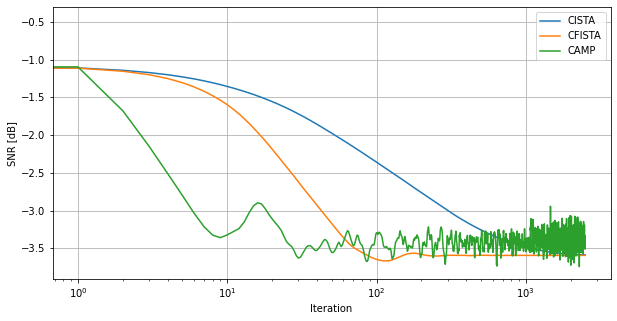

In [14]:
x_hat, nmses = ista_denoise(y, A,x, 1.9, 2500)
x_hat1, nmses1 = fista_denoise(y, A,x, 2.0, 2500)
x_hat2, nmses2 = amp_denoise(y, A,x, 0.68, 2500)

plt.figure(figsize = (10,5))
plt.plot(toDb(nmses), label ='CISTA')
plt.plot(toDb(nmses1), label ='CFISTA')
plt.plot(toDb(nmses2), label ='CAMP')


plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR [dB]')

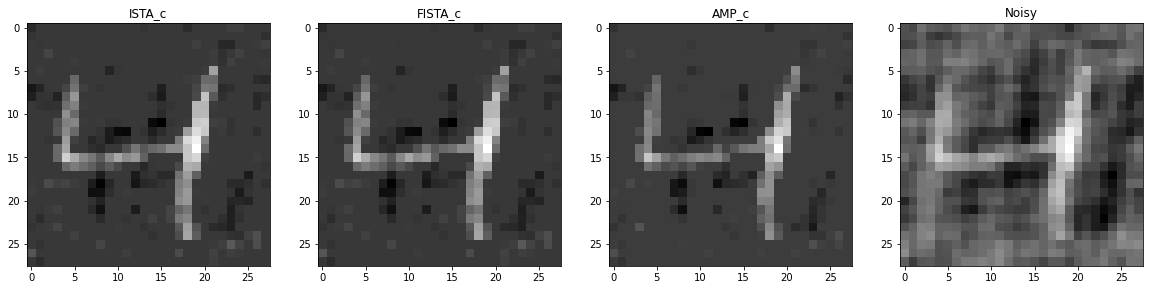

In [156]:
plt.figure(figsize =(20,5))

plt.subplot(1,4,1)
plt.imshow(x_hat.real.reshape(28,28), cmap = 'gray')
plt.title('ISTA_c')

plt.subplot(1,4,2)
plt.imshow(x_hat1.real.reshape(28,28), cmap = 'gray')
plt.title('FISTA_c')

plt.subplot(1,4,3)
plt.imshow(x_hat2.real.reshape(28,28), cmap = 'gray')
plt.title('AMP_c')

plt.subplot(1,4,4)
plt.title('Noisy')
plt.imshow(((torch.linalg.pinv(A)@y).real) .reshape(28,28), cmap = 'gray')

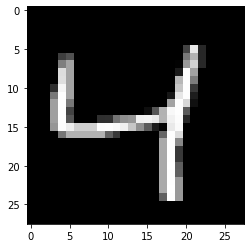

In [15]:
x = np.copy(X[2,:].reshape(28,28))
plt.imshow(x, cmap = 'gray')

In [16]:
import scipy
from scipy import fftpack

def dct2(x):
    return fftpack.dct(fftpack.dct(x.T, norm='ortho').T, norm='ortho')

def idct2(x):
    return fftpack.idct(fftpack.idct(x.T, norm='ortho').T, norm='ortho')

In [18]:
A = get_partial_FFT(M = 300, N =28**2)
x = torch.tensor(np.copy(X[2,:]).reshape(-1,1), dtype= torch.complex128)
y = A@x 

Text(0, 0.5, 'SNR [dB]')

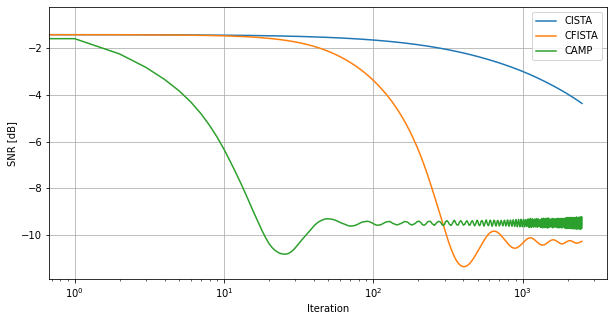

In [26]:
x_hat, nmses = ista_denoise(y, A,x, 0.1, 2500)
x_hat1, nmses1 = fista_denoise(y, A,x, 0.1, 2500)
x_hat2, nmses2 = amp_denoise(y, A,x, 0.77, 2500)

plt.figure(figsize = (10,5))
plt.plot(toDb(nmses), label ='CISTA')
plt.plot(toDb(nmses1), label ='CFISTA')
plt.plot(toDb(nmses2), label ='CAMP')


plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR [dB]')

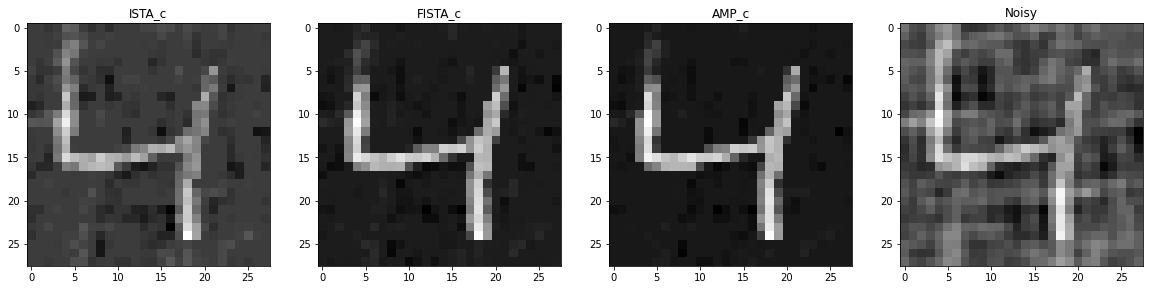

In [28]:
plt.figure(figsize =(20,5))

plt.subplot(1,4,1)
plt.imshow(x_hat.reshape(28,28).real, cmap = 'gray')
plt.title('ISTA_c')

plt.subplot(1,4,2)
plt.imshow(x_hat1.reshape(28,28).real, cmap = 'gray')
plt.title('FISTA_c')

plt.subplot(1,4,3)
plt.imshow(x_hat2.reshape(28,28).real, cmap = 'gray')
plt.title('AMP_c')

plt.subplot(1,4,4)
plt.title('Noisy')
plt.imshow(((torch.linalg.pinv(A)@y).real) .reshape(28,28), cmap = 'gray')

In [30]:
x_dct = torch.tensor(dct2(np.copy(X[2,:]).reshape(28,28)).reshape(-1,1), dtype= torch.complex128)
y_dct = A @ x_dct 

Text(0, 0.5, 'SNR [dB]')

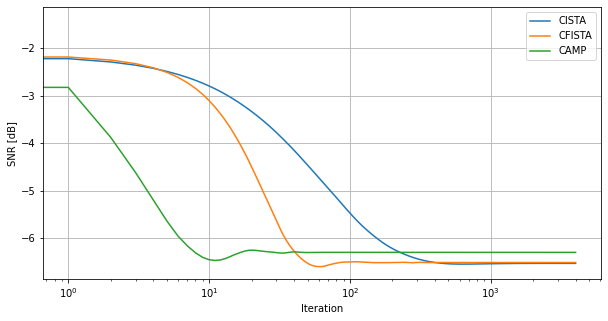

In [35]:
x_hat, nmses = ista_denoise(y_dct, A,x_dct, 1.9, 4000)
x_hat1, nmses1 = fista_denoise(y_dct, A,x_dct, 1.4, 4000)
x_hat2, nmses2 = amp_denoise(y_dct, A,x_dct, 0.8, 4000)

plt.figure(figsize = (10,5))
plt.plot(toDb(nmses), label ='CISTA')
plt.plot(toDb(nmses1), label ='CFISTA')
plt.plot(toDb(nmses2), label ='CAMP')


plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR [dB]')

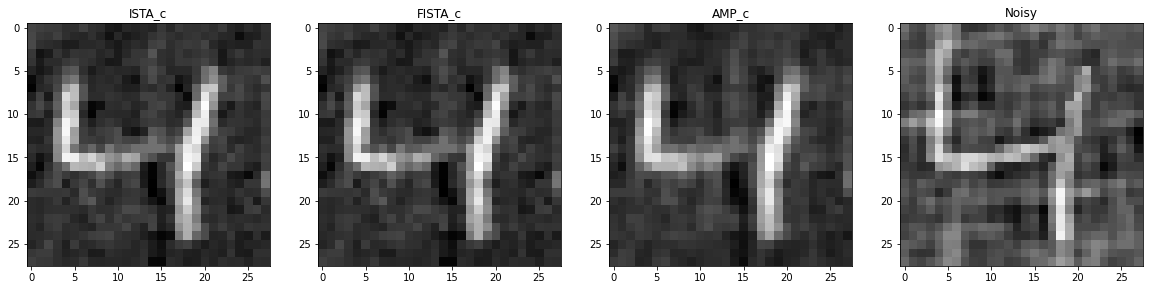

In [36]:
plt.figure(figsize =(20,5))

plt.subplot(1,4,1)
plt.imshow(idct2(x_hat.reshape(28,28).numpy()).real, cmap = 'gray')
plt.title('ISTA_c')

plt.subplot(1,4,2)
plt.imshow(idct2(x_hat1.reshape(28,28).numpy()).real, cmap = 'gray')
plt.title('FISTA_c')

plt.subplot(1,4,3)
plt.imshow(idct2(x_hat2.reshape(28,28).numpy()).real, cmap = 'gray')
plt.title('AMP_c')

plt.subplot(1,4,4)
plt.title('Noisy')
plt.imshow(((torch.linalg.pinv(A)@y)) .reshape(28,28).real, cmap = 'gray')

In [37]:
hhh = idct2(x_hat.reshape(28,28).numpy()).reshape(-1,1)
hhh1 = idct2(x_hat1.reshape(28,28).numpy()).reshape(-1,1)
hhh2 = idct2(x_hat2.reshape(28,28).numpy()).reshape(-1,1)

Text(0, 0.5, 'SNR [dB]')

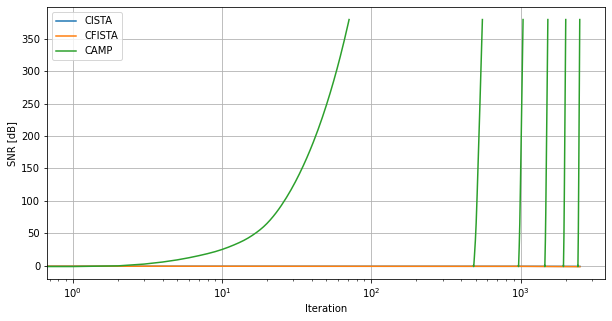

In [38]:
x_ht, nmses = ista_denoise(A@torch.tensor(hhh), A,x , 0.01, 2500)
x_h1, nmses1 = fista_denoise(A@torch.tensor(hhh1), A,x, 0.0001, 2500)
x_h2, nmses2 = amp_denoise(A@torch.tensor(hhh2), A, x, 0.45, 2500)

plt.figure(figsize = (10,5))
plt.plot(toDb(nmses), label ='CISTA')
plt.plot(toDb(nmses1), label ='CFISTA')
plt.plot(toDb(nmses2), label ='CAMP')


plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR [dB]')

TypeError: Image data of dtype complex128 cannot be converted to float

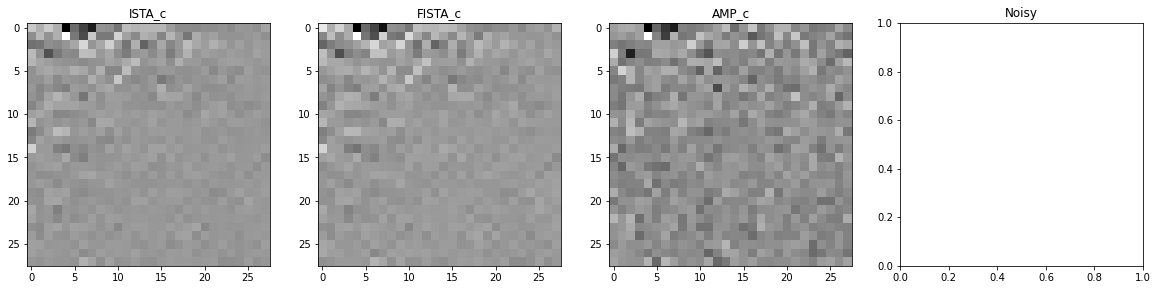

In [40]:
plt.figure(figsize =(20,5))

plt.subplot(1,4,1)
plt.imshow(idct2(x_ht.reshape(28,28).numpy()).real, cmap = 'gray')
plt.title('ISTA_c')

plt.subplot(1,4,2)
plt.imshow(idct2(x_h1.reshape(28,28).numpy()).real, cmap = 'gray')
plt.title('FISTA_c')

plt.subplot(1,4,3)
plt.imshow(idct2(x_h2.reshape(28,28).numpy()).real, cmap = 'gray')
plt.title('AMP_c')

plt.subplot(1,4,4)
plt.title('Noisy')
plt.imshow(((torch.linalg.pinv(A)@y)) .reshape(28,28), cmap = 'gray')

In [42]:
class Lista(torch.nn.Module):
    def __init__(self, A, layers, beta = 1.0,) -> None:
        super(Lista, self).__init__()
        INIT_LAMBDA = 0.001

        M,N = A.shape[0], A.shape[1]
        In = torch.eye(N)
        B = beta * torch.conj(A).T

        self.B = torch.nn.Parameter(B, requires_grad = True)
        self.S = torch.nn.Parameter(In-B@A, requires_grad=True)

        self.lambdas = torch.nn.Parameter(torch.ones(layers+1)*INIT_LAMBDA, requires_grad = True)      
        self.layers = layers
        
    def forward(self, y):
        By = self.B @ y 
        x_hat = act.threshold(By, lambd = self.lambdas[0], type= 'soft')

        for layer in range(self.layers):
            r = By + self.S @ x_hat
            x_hat = act.threshold(r, lambd=self.lambdas[layer+1])
        
        return x_hat


In [44]:
# lernable algorithm 

from recoverers.lernable import Lista

lista = Lista(A = A, layers = 16)
optimizer = torch.optim.Adam(lista.parameters(), lr = 1.0e-4)
loss_f = torch.nn.MSELoss()

losses = []
metrics = []
for i in range(1000):
    optimizer.zero_grad()

    x_hat = lista.forward(y)
    
    
    loss_value = MSE(x_hat, x)
    metric = NMSE(x_hat, x)

    losses.append(loss_value)
    metrics.append(metric)

    loss_value.backward()
    optimizer.step()

Text(0, 0.5, 'SNR [dB]')

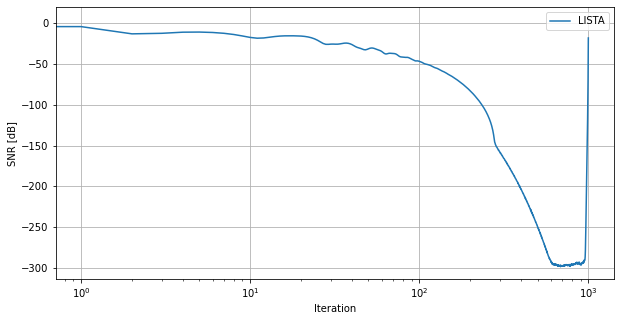

In [46]:
plt.figure(figsize = (10,5))
#plt.plot(toDb(nmses), label ='ISTA')
#plt.plot(toDb(nmses2), label ='FISTA')
#plt.plot(toDb(nmses3), label ='AMP')
plt.plot(toDb(torch.tensor(metrics)), label ='LISTA')

plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR [dB]')

In [9]:
X.shape

(70000, 784)

In [24]:
def train_net(Images, model, optimizer, A):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print('Starting Training using device : ', device)

    model.to(device)
    criterion = MSE
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [20,30], gamma = 0.1)  
    n_epochs = 100
    
    train_mses = []
    test_mses = []

    for epoch in range(n_epochs):
        model.train()
        current_mse = 0
        optimizer.zero_grad() 

        # training 
        for n_img in range(300):
            x = torch.tensor(Images[n_img,:], dtype= torch.complex128).to(device)
            #A = get_partial_FFT(392,784)
            n = get_noise(x.real, SNR_dB = 40)
            n = n +1j*0
            y = A@(x+n)
            x_hat = model(y)
            loss = criterion(x, x_hat)
            current_mse += loss
        
        current_mse.backward()
        optimizer.step()
        train_mses.append(current_mse.item())

        model.eval()
        test_mse = 0
        for n_img in range(300,350):
            x = torch.tensor(Images[n_img,:], dtype= torch.complex128).to(device)
            n = get_noise(x.real, SNR_dB = 40)
            n = n +1j*0
            y = A@(x+n)
            x_hat = model(y)
            loss = criterion(x, x_hat)
            test_mse += loss
        test_mses.append(test_mse.item())

        print('Epoch: {0}. Train Loss : {1}. Test Loss: {2}'.format(epoch, current_mse, test_mse))

    return model, train_mses, test_mses

In [25]:
from recoverers.lernable import Lista

A = get_partial_FFT(392,784)
lista = Lista(A = A, layers = 16)
optimizer = torch.optim.Adam(lista.parameters(), lr = 1.0e-4)

model, train_loss, test_loss = train_net(X, lista, optimizer, A)


Starting Training using device :  cpu
Epoch: 0. Train Loss : 1102564.9585239585. Test Loss: 85827.80904404176
Epoch: 1. Train Loss : 500929.9158982683. Test Loss: 81506.36717311534
Epoch: 2. Train Loss : 457940.93357356405. Test Loss: 79657.1565020865
Epoch: 3. Train Loss : 437457.7193781036. Test Loss: 66113.27329689651
Epoch: 4. Train Loss : 348369.87810888555. Test Loss: 53585.51829229884
Epoch: 5. Train Loss : 266668.52115012537. Test Loss: 46432.844461453824
Epoch: 6. Train Loss : 218781.15382535147. Test Loss: 44114.74499130979
Epoch: 7. Train Loss : 200791.21545679413. Test Loss: 43995.11534964329
Epoch: 8. Train Loss : 195735.75868475728. Test Loss: 44022.653778105094
Epoch: 9. Train Loss : 191285.30705735195. Test Loss: 43640.80282016742
Epoch: 10. Train Loss : 184184.18590633085. Test Loss: 42796.1732025057
Epoch: 11. Train Loss : 174752.64948527506. Test Loss: 41567.5150644567
Epoch: 12. Train Loss : 163243.37711769695. Test Loss: 40131.77918980224
Epoch: 13. Train Loss : 15

KeyboardInterrupt: 

In [31]:
for name, param in lista.named_parameters():
    if param.requires_grad:
        print(name, param.data)

B tensor([[ 0.0355+3.0423e-04j,  0.0340+1.8425e-03j,  0.0361+1.4748e-03j,
          ...,  0.0367-4.0314e-04j,  0.0357-7.8939e-06j,
          0.0343+7.3944e-05j],
        [ 0.0231-2.6872e-02j, -0.0187-2.9878e-02j,  0.0258+2.4604e-02j,
          ..., -0.0321+1.2014e-02j,  0.0349+7.6915e-03j,
          0.0275-1.9423e-02j],
        [-0.0046-3.4941e-02j, -0.0165+2.9087e-02j,  0.0005+3.5506e-02j,
          ...,  0.0296-2.3914e-02j,  0.0325+1.5032e-02j,
          0.0116-3.1745e-02j],
        ...,
        [-0.0304+1.9049e-02j,  0.0341+1.9439e-03j, -0.0237-2.6758e-02j,
          ..., -0.0187-2.9592e-02j,  0.0285-2.1635e-02j,
         -0.0072+3.2722e-02j],
        [-0.0054+3.5540e-02j, -0.0164-2.9624e-02j,  0.0011-3.5685e-02j,
          ...,  0.0261+2.1646e-02j,  0.0325-1.5120e-02j,
          0.0129+3.1729e-02j],
        [ 0.0229+2.6485e-02j, -0.0184+3.1172e-02j,  0.0260-2.3958e-02j,
          ..., -0.0305-1.1338e-02j,  0.0349-7.7490e-03j,
          0.0284+1.9573e-02j]], dtype=torch.complex128)


In [32]:
x = torch.tensor(X[50,:], dtype= torch.complex128)
n = get_noise(x.real, SNR_dB = 40)
n = n +1j*0
y = A@(x+n)
x_hat = lista(y)

In [ ]:
plt.imshow()

In [40]:
(torch.linalg.pinv(A)@y).shape

torch.Size([784])

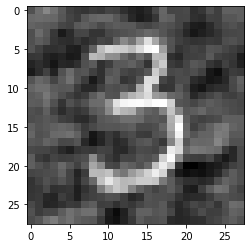

In [43]:
plt.imshow((torch.linalg.pinv(A)@y).real.reshape(28,28), cmap = 'gray')

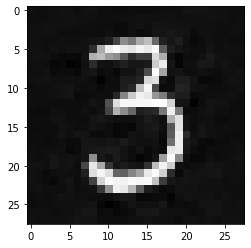

In [44]:
plt.imshow(x_hat.detach().numpy().real.reshape(28,28), cmap = 'gray')

In [1]:
from sklearn.datasets import fetch_openml
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [10]:
from metrics import PSNR,NMSE,SSIM
import torch
from tqdm import tqdm

def get_metrics(img_original,img_noisy,printt=False):
    mse = torch.nn.MSELoss()
    psnr,msee = PSNR(img_original,img_noisy),mse(img_original,img_noisy).item()
    nmse,ssim = NMSE(img_original,img_noisy),SSIM(img_original,img_noisy)
    if printt:
        print('Calculated metrics:')
        print('PSNR =',psnr)
        print('MSE  =',msee)
        print('NMSE =',nmse)
        print('SSIM =',ssim)
    return psnr,msee,nmse,ssim

def exp12(matrix,X,iters,SNRdB):
    metrics = {'ISTA':[],'FISTA':[],'AMP':[],'NOISY':[]}
    nmses = {'ISTA':[],'FISTA':[],'AMP':[]}
    N = 784
    M = N // 2
    for i in tqdm(range(iters)):
        # use current image
        x = X[i,:].reshape(-1,1)
        # gaussian measure matrix
        if matrix == 'G':
            A = np.random.normal(size = (M,N), scale = 1.0/np.sqrt(M)).astype(np.float32)
            A = torch.tensor(A / np.linalg.norm(A,ord=2),dtype = torch.float32)
            x = torch.tensor(x,dtype = torch.float32)
        # fourier measure matrix
        elif matrix == 'F':
            A = get_partial_FFT(M,N).to(torch.complex64)
            x = torch.tensor(x, dtype = torch.complex64)
        # gen noise
        n = get_noise(A @ x, SNRdB)
        # add noise
        y = A @ x + n

        # try algorithms
        x_hat0, nmse0  = ista_denoise(y, A, x, 1.9, 2500)
        x_hat1, nmse1 = fista_denoise(y, A, x, 2.0, 2500)
        x_hat2, nmse2 = amp_denoise(y, A, x, 0.68, 2500)
        x_hat3 = (torch.linalg.pinv(A) @ y)
        
        nmses['ISTA'].append(np.array(nmse0))
        nmses['FISTA'].append(np.array(nmse1))
        nmses['AMP'].append(np.array(nmse2))

        # convert types
        if x.dtype == torch.complex64: x = x.real
        if x_hat0.dtype == torch.complex64: x_hat0 = x_hat0.real
        if x_hat1.dtype == torch.complex64: x_hat1 = x_hat1.real
        if x_hat2.dtype == torch.complex64: x_hat2 = x_hat2.real
        if x_hat3.dtype == torch.complex64: x_hat3 = x_hat3.real

        # calculate metrics  
        x = x.reshape(28,28)
        metrics['ISTA'].append(get_metrics(x,x_hat0.reshape(28,28)))
        metrics['FISTA'].append(get_metrics(x,x_hat1.reshape(28,28)))
        metrics['AMP'].append(get_metrics(x,x_hat2.reshape(28,28)))
        metrics['NOISY'].append(get_metrics(x,x_hat3.reshape(28,28)))
    return metrics,nmses

iters = 10
SNRdB = 40

matrix = 'G'
metricsG,nmsesG = exp12(matrix,X,iters,SNRdB)

matrix = 'F'
metricsF,nmsesF = exp12(matrix,X,iters,SNRdB)

100%|██████████| 10/10 [00:24<00:00,  2.49s/it]


In [11]:
print('    psnr','msee','nmse','ssim')
print('ISTA ',np.array(metricsG['ISTA']).mean(axis=0))
print('FISTA',np.array(metricsG['FISTA']).mean(axis=0))
print('AMP  ',np.array(metricsG['AMP']).mean(axis=0))
print('NOISY',np.array(metricsG['NOISY']).mean(axis=0))

    psnr msee nmse ssim
ISTA  [2.39246047e+01 8.46615389e+02 9.82568118e-02 8.45639182e-01]
FISTA [2.36611568e+01 8.60890187e+02 1.00329194e-01 8.42031454e-01]
AMP   [2.26359344e+01 2.21694536e+03 2.71544640e-01 6.34767963e-01]
NOISY [1.32267689e+01 3.30041422e+03 5.07005990e-01 3.63009508e-01]


In [12]:
print('    psnr','msee','nmse','ssim')
print(f'ISTA ',np.array(metricsF['ISTA']).mean(axis=0))
print('FISTA',np.array(metricsF['FISTA']).mean(axis=0))
print('AMP  ',np.array(metricsF['AMP']).mean(axis=0))
print('NOISY',np.array(metricsF['NOISY']).mean(axis=0))

    psnr msee nmse ssim
ISTA  [4.17155886e+01 1.50783395e+01 1.67294381e-03 9.90271836e-01]
FISTA [4.13565725e+01 1.55242218e+01 1.73543380e-03 9.90229371e-01]
AMP   [2.65457433e+01 3.46410429e+06 4.32810246e+02 8.21564849e-01]
NOISY [1.48789413e+01 2.29488503e+03 3.53695913e-01 3.67288311e-01]


Text(0, 0.5, 'SNR [dB]')

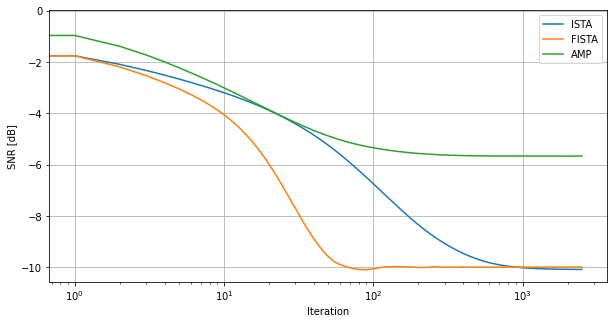

In [13]:
plt.figure(figsize = (10,5))
plt.plot(toDb(torch.tensor(np.array(nmsesG['ISTA']).mean(axis=0))), label ='ISTA')
plt.plot(toDb(torch.tensor(np.array(nmsesG['FISTA']).mean(axis=0))), label ='FISTA')
plt.plot(toDb(torch.tensor(np.array(nmsesG['AMP']).mean(axis=0))), label ='AMP')
plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('SNR [dB]')

In [17]:
def exp3(matrix,X,iters,SNRdB):
    metrics000 = []
    nmses000 = []
    N = 784
    M = N // 2
    for snrdb in SNRdB:
        metrics = {'ISTA':[]}
        nmses = {'ISTA':[]}
        for i in tqdm(range(iters)):
            # use current image
            x = X[i,:].reshape(-1,1)
            # fourier measure matrix
            A = get_partial_FFT(M,N).to(torch.complex64)
            x = torch.tensor(x, dtype = torch.complex64)
            # gen noise
            n = get_noise(A @ x, snrdb)
            # add noise
            y = A @ x + n

            # try algorithms
            x_hat0, nmse0  = ista_denoise(y, A, x, 1.9, 2500)

            nmses['ISTA'].append(np.array(nmse0))

            # convert types
            if x.dtype == torch.complex64: x = x.real
            if x_hat0.dtype == torch.complex64: x_hat0 = x_hat0.real

            # calculate metrics  
            x = x.reshape(28,28)
            metrics['ISTA'].append(get_metrics(x,x_hat0.reshape(28,28)))
        metrics000.append(metrics)
        nmses000.append(nmses)
    return metrics000,nmses000

matrix = 'F'
iters = 3
SNRdB = np.linspace(10,40,4)

exp3(matrix,X,iters,SNRdB)

100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


([{'ISTA': [(13.155303955078125,
     3144.487548828125,
     0.4150296449661255,
     0.4063695404990444),
    (19.063430786132812,
     806.7470703125,
     0.0936974436044693,
     0.8275340721514495),
    (20.863407135009766,
     533.0154418945312,
     0.10843055695295334,
     0.5789456048611226)]},
  {'ISTA': [(29.083097457885742,
     80.3102035522461,
     0.01059985626488924,
     0.9499202734890299),
    (28.435840606689453,
     93.21725463867188,
     0.010826464742422104,
     0.9557862735119114),
    (33.40951919555664,
     29.657081604003906,
     0.006033096928149462,
     0.945116108311717)]},
  {'ISTA': [(35.640289306640625,
     17.743995666503906,
     0.002341966377571225,
     0.9927860108873463),
    (37.66712951660156,
     11.126729965209961,
     0.0012922837631776929,
     0.9948800340684095),
    (28.650272369384766,
     88.72645568847656,
     0.018049493432044983,
     0.9426966385129587)]},
  {'ISTA': [(44.5277099609375,
     2.2924981117248535,
     